In [ ]:
"""
Data set: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
"""

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
from sklearn.model_selection import train_test_split
import _pickle as pickle
from typing import List
import os
from collections import defaultdict
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
import matplotlib
from matplotlib import pyplot as plt
plt.style.use("seaborn-dark")

Using TensorFlow backend.


In [2]:
import json_rec
from data_import import load_embedding_from_disks

In [3]:
# df = pd.read_csv("./data/text_emotion.csv")
df = pd.read_csv(
    "/home/ec2-user/data/training.1600000.processed.noemoticon.csv", header=None, encoding = "ISO-8859-1")
df_test = pd.read_csv(
    "/home/ec2-user/data/testdata.manual.2009.06.14.csv", header=None, encoding = "ISO-8859-1")

In [4]:
df.columns = ["polarity", "id", "date", "query", "user", "text"]
print(f"Total training observations: {len(df)}")
df.head()  

Total training observations: 1600000


,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
if not os.path.exists("./saved_model"):
    os.mkdir("./saved_model")
now = datetime.datetime.now()
model_dir = "./saved_model/" + now.strftime("%Y-%m-%d-%H:%M")
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    os.mkdir(model_dir + "/tensorboard")

In [6]:
param_writer = json_rec.ParamWriter()

In [50]:
# Parameter
# GLOVE_FILENAME = "../data/glove.840B.300d.txt"
use_default = bool(input("Use default param? >>> ").upper() == "Y")
if use_default:
    param = dict(
        GLOVE_FILENAME="../data/glove.6B.50d.txt",
        lstm_units=(256, 512),
        epochs=50,
        max_seq_length=25
    )
else:
    config_file = input("Directory of config file >>> ")
    param_writer.read(config_file)

Use default param? >>> Y


In [8]:
json_rec.write_param(param, "./sample_config.json")

In [9]:
print("Loading embedding from disks...")
word_to_index, index_to_embedding = load_embedding_from_disks(
    param["GLOVE_FILENAME"],
    with_indexes=True
)
print("Embedding loaded from disks.")

10634it [00:00, 53173.47it/s]

Loading embedding from disks...


400000it [00:07, 53444.46it/s]


Embedding loaded from disks.


In [10]:
vocab_size, embedding_dim = index_to_embedding.shape
print(f"Embedding matrix loaded, Vocab Size: {vocab_size}\nEmbedding Dim: {embedding_dim}")
globals().update(param)

Embedding matrix loaded, Vocab Size: 400001
Embedding Dim: 50


In [11]:
def word2int(w: str) -> int:
    try:
        idx = word_to_index[w]
    except KeyError:
        idx = word_to_index["unk"]
    return idx

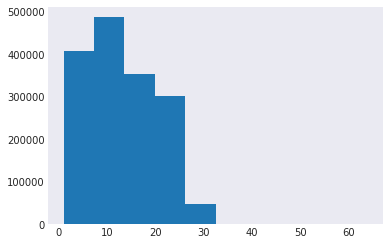

In [51]:
lengths = [len(x.split()) for x in df["text"]]
plt.hist(lengths)
plt.show()

In [13]:
X_lst, y_lst = [], []
for sentence, polarity in tqdm(zip(df["text"], df["polarity"])):
    # ==== Encode x ====
    tokens = sentence.lower().split()
    word_ints = np.array([word2int(x) for x in tokens])
    X_lst.append(word_ints)
    
    # ==== Encode y ====
    y_lst.append(polarity)

1600000it [00:13, 120844.42it/s]


In [14]:
X_lst = pad_sequences(
    X_lst,
    maxlen=max_seq_length,
    padding="post",
    truncating="post"
)

In [35]:
X_raw = np.stack(X_lst)
y_raw = np.stack(y_lst).reshape(-1,1)
print(X_raw.shape)
print(y_raw.shape)
X_raw = X_raw[:16000]
y_raw = y_raw[:16000]

(1600000, 25)
(1600000, 1)


In [36]:
(X_train, X_val,
 y_train, y_val) = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    shuffle=True
)

In [37]:
print(f"Training and testing set generated,\
\nX_train shape: {X_train.shape}\
\ny_train shape: {y_train.shape}\
\nX_validation shape: {X_val.shape}\
\ny_validation shape: {y_val.shape}")

Training and testing set generated,
X_train shape: (12800, 25)
y_train shape: (12800, 1)
X_validation shape: (3200, 25)
y_validation shape: (3200, 1)


In [39]:
X_train_batches = X_train.reshape(25, 512, max_seq_length)
y_train_batches = y_train.reshape(25, 512, 1)
X_val_batches = X_val.reshape(32, 100, max_seq_length)
y_val_batches = y_val.reshape(32, 100, 1)
print(f"X batches shape: {X_train_batches.shape}")
print(f"y batches shape: {y_train_batches.shape}")

X batches shape: (25, 512, 25)
y batches shape: (25, 512, 1)


In [77]:
try:
    sess.close()
except NameError:
    print("Session already cleaned.")

In [78]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

with tf.name_scope("DATA_IO"):
    word_ids = tf.placeholder(
        tf.int32,
        shape=[None, max_seq_length]
    )
    
    y = tf.placeholder(
        tf.float32,
        shape=[None, 1]
    )

with tf.name_scope("EMBEDDING"):
    embedding = tf.Variable(
        tf.constant(0.0, shape=index_to_embedding.shape),
        trainable=False,
        name="EMBEDDING"
    )
    
    word_representation_layer = tf.nn.embedding_lookup(
        params=embedding,
        ids=word_ids
    )
    
    embedding_placeholder = tf.placeholder(
        tf.float32,
        shape=index_to_embedding.shape
    )
    
    embedding_init = embedding.assign(embedding_placeholder)
    
    _ = sess.run(
        embedding_init, 
            feed_dict={
                embedding_placeholder: index_to_embedding
        }
    )

cell = tf.nn.rnn_cell.MultiRNNCell(
    [tf.nn.rnn_cell.LSTMCell(
        num_units=units,
        name=f"LSTM_LAYER_{i}")
        for i, units in enumerate(lstm_units)
     ])

lstm_cell = tf.contrib.rnn.DropoutWrapper(
    cell=cell,
    output_keep_prob=0.75
)
outputs, state = tf.nn.dynamic_rnn(
    lstm_cell, 
    word_representation_layer,
    dtype=tf.float32
)

with tf.name_scope("OUTPUT"):
    weight = tf.Variable(
        tf.truncated_normal(
            [lstm_units[-1], 1]
        )
    )
    
    bias = tf.Variable(
        tf.random_normal(shape=[1])
    )

# Option i)
#     value = tf.transpose(outputs, [1, 0, 2])
#     last = tf.gather(value, int(value.get_shape()[0]) - 1)
# Option ii)
    last = outputs[:, -1, :]
    pred = tf.matmul(last, weight) + bias
    pred_sig = tf.sigmoid(pred) * 4

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [79]:
with tf.name_scope("LOSSES"):
    loss = tf.reduce_mean(
        tf.square(pred - y)
    )
    optimizer = tf.train.AdamOptimizer(learning_rate=0.03)
    train_op = optimizer.minimize(loss)
    tf.summary.scalar("Loss", loss)

In [80]:
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

merged = tf.summary.merge_all()
logdir = model_dir + "/tensorboard/"
writer = tf.summary.FileWriter(logdir, sess.graph)

for e in range(epochs):
    for X_batch, y_batch in zip(X_train_batches, y_train_batches):
        sess.run(
            train_op,
            feed_dict={
                word_ids: X_batch,
                y: y_batch
            }
        )

    if e % 5 == 0:
        summary = sess.run(
            merged,
            feed_dict={
                word_ids: X_val,
                y: y_val
            }
        )
    if e % 1 == 0:
        train_mse = []
        val_mse = []
        for X_batch, y_batch in zip(X_train_batches, y_train_batches):
            train_mse.append(
                loss.eval(
                    feed_dict={word_ids: X_batch, y: y_batch}
            ))
        avg_tarin_mse = np.mean(train_mse)
        
        for X_batch, y_batch in zip(X_val_batches, y_val_batches):
            val_mse.append(
                loss.eval(feed_dict={word_ids: X_batch, y: y_batch}
            ))
        avg_val_mse = np.mean(val_mse)
        print(
            f"Epochs[{e}]: train batch avg accuracy={avg_tarin_mse}, val accuracy={avg_val_mse}")
    writer.add_summary(summary, e)
    writer.close()

Epochs[0]: train batch avg accuracy=6.2331929206848145, val accuracy=6.184423446655273
Epochs[1]: train batch avg accuracy=6.195934295654297, val accuracy=6.493029594421387
Epochs[2]: train batch avg accuracy=4.158578395843506, val accuracy=4.397254467010498
Epochs[3]: train batch avg accuracy=3.3997583389282227, val accuracy=3.2550415992736816
Epochs[4]: train batch avg accuracy=2.5666208267211914, val accuracy=2.5964338779449463
Epochs[5]: train batch avg accuracy=1.735917091369629, val accuracy=1.7137882709503174
Epochs[6]: train batch avg accuracy=1.4311617612838745, val accuracy=1.3726218938827515
Epochs[7]: train batch avg accuracy=1.1781712770462036, val accuracy=1.1968326568603516
Epochs[8]: train batch avg accuracy=0.9787371158599854, val accuracy=1.0045100450515747
Epochs[9]: train batch avg accuracy=0.853961706161499, val accuracy=0.8671680092811584


In [81]:
f = lambda src: pred_sig.eval(feed_dict={word_ids: src})
train_pred = f(X_train)
val_pred = f(X_val)

(array([ 206.,  793., 1347., 1709., 1925., 2140., 1951., 1556.,  915.,
         258.]),
 array([0.13210487, 0.50355723, 0.87500958, 1.24646194, 1.6179143 ,
        1.98936665, 2.36081901, 2.73227136, 3.10372372, 3.47517607,
        3.84662843]),
 <a list of 10 Patch objects>)

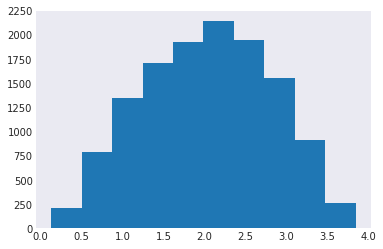

In [82]:
plt.hist(train_pred)

In [87]:
tf.saved_model.simple_save(
            sess,
            export_dir=f"{model_dir}/model",
            inputs={"DATA_IO/word_ids": word_ids, "DATA_IO/y": y},
            outputs={"OUTPUT/pred": pred, "OUTPUT/pred_sig": pred_sig}
)

AssertionError: Export directory already exists. Please specify a different export directory: ./saved_model/2019-01-20-06:37/model

In [88]:
def sentence2ints(sentence):
    tokens = sentence.split()
    ids = [word_to_index[word] for word in tokens]
    ids = pad_sequences([ids], maxlen=max_seq_length, padding="post", truncating="post")
    return np.array(ids)

In [106]:
int_sen = sentence2ints(sen)
print(pred_sig.eval(feed_dict={word_ids: int_sen}))

[[2.9689612]]


In [98]:
pred_sig.eval(feed_dict={word_ids: int_sen})

array([[3.2815456]], dtype=float32)